Updated PSD: subset the low/high 70Hz cluster, then plot relative PSD for each cluster

"channels_interest = ['EEG 3', 'EEG 4', 'EEG 7', 'EEG 10', 'EEG 11', 'EEG 12'] #channels that have signal (-0 for python indexing)
"channel_names = ['OFC_right', 'S_right', 'EMG_right', 'EMG_left', 'S_left', 'OFC_left' ] # corresponding channel names   

In [13]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mne
from scipy.signal import spectrogram

In [2]:
# Specify folder path to batch 1
b1_preproc_folder_epochs = 'b1/folder_epochs' # epochs
b1_sliced_folder_epochs = 'b1/folder_epochs/sliced_epochs_KMEANS' # sliced epochs

# Specify folder path to batch 2
b2_preproc_folder_epochs = 'b2/folder_epochs' # epochs
b2_sliced_folder_epochs = 'b2/folder_epochs/sliced_epochs_KMEANS' # sliced epochs

# Define channels
channels_interest = ['EEG 3', 'EEG 4', 'EEG 11', 'EEG 12'] # define channels that have signal (-0 for python indexing)
channel_names = ['OFC_right', 'S_right', 'S_left', 'OFC_left' ] # corresponding channel names    

all_animals = ['8.1', '8.2', '8.3', '8.4', '8.5', '8.6', '8.7', '8.8', '8.9', '8.10', '8.11', '8.12', '8.13', '8.14', '8.15', '8.16']


In [3]:
# Define stuff for plotting
# sns.set_palette('rocket')

# Define custom palette
custom_palette = {
    'Saline': '#f6b48f',
    'CNO1': '#e13342',
    'CNO5': '#ad1759',
    'CNO10': '#701f57'
}

# Define the order of channels and legend treatments
channel_order = ['OFC_left', 'OFC_right', 'S_left', 'S_right']
legend_order = ['Saline', 'CNO1', 'CNO5', 'CNO10']

duration_hours = 2

In [5]:
# BATCH 1
# Create dataframe
df = pd.DataFrame()

# Loop through all files in the raw epoch folder
for preproc_filename in os.listdir(b1_preproc_folder_epochs):
    if not preproc_filename.endswith('epo.fif'):
        continue        

    preproc_file_path = os.path.join(b1_preproc_folder_epochs, preproc_filename)
    preproc_data = mne.read_epochs(preproc_file_path, 
                                   preload=False)
    
    for sliced_filename in os.listdir(b1_sliced_folder_epochs):
        if not sliced_filename.endswith("epo.fif"):
            continue

        if preproc_filename in sliced_filename:
            # Read sliced epochs:
            sliced_epochs = mne.read_epochs(os.path.join(b1_sliced_folder_epochs, sliced_filename), preload=False)
            print(f"Selected sliced epochs: {sliced_filename}")
            print(f"Selected preprocessed epochs: {preproc_filename}")
        
            # # select 1 hr instead of 2hrs epochs
            # start_timepoint = 0 # Index of epoch. 
            # duration_hours = 1

            # duration_epochs = duration_hours * 60 * 12  # 60 minutes/hour * 12 epochs/minute
            # end_timepoint = start_timepoint + duration_epochs
            # sliced_epochs = sliced_epochs[start_timepoint:end_timepoint]

            # Slice preprocessed file based on the index of the metadata of the sliced_epochs
            sliced_preproc = preproc_data[sliced_epochs.metadata.index]
            sliced_preproc.metadata = pd.concat([sliced_preproc.metadata, sliced_epochs.metadata["Cluster_Label"]], axis=1)

            # Replace treatment names
            replacement_map = {
            'cno1': 'CNO1',
            'cno5': 'CNO5',
            'cno5-2': 'CNO5',
            'cno10': 'CNO10',
            'saline2': 'Saline',
            'Saline2': 'Saline',
            'Saline3': 'Saline'}

            for old_value, new_value in replacement_map.items():
                sliced_preproc.metadata['Treatment'] = sliced_preproc.metadata['Treatment'].replace([old_value], new_value)

            # Replace Surgery names
            sliced_preproc.metadata['Surgery'] = sliced_preproc.metadata['Surgery'].replace('mcherry', 'mCherry')
            sliced_preproc.metadata['Surgery'] = sliced_preproc.metadata['Surgery'].replace('DREADD', 'DREADDs')

            # Get from metadata
            animal_id = sliced_preproc.metadata['Animal'].unique()[0]
            treatment = sliced_preproc.metadata['Treatment'].unique()[0]
            surgery = sliced_preproc.metadata['Surgery'].unique()[0]
            cluster_label = sliced_preproc.metadata['Cluster_Label']
            sfreq = sliced_preproc.info['sfreq']

            print(f"Selected: {animal_id} {treatment}")
            # Match is found, break inner loop
            break
                    
    for channel, ch_name in zip(channels_interest, channel_names):
        for cl in ['High_70Hz', 'Low_70Hz']:
            # Exract cluster epochs
            cluster_epochs = sliced_preproc[sliced_preproc.metadata['Cluster_Label']==cl]

            # Calculate the PSD for all datasets  
            psds, freqs = mne.time_frequency.psd_array_multitaper(cluster_epochs.get_data(channel), fmin=0, fmax=100, sfreq=sfreq)
            mean_psd = np.mean(psds[:, 0, :], axis=0)
            median_psd = np.median(psds[:, 0, :], axis=0)

            # Calculate total power, relative PSD and mean relative PSD
            total_power = np.sum(psds, axis=-1)        
            rel_psd = psds / total_power[:, np.newaxis]
            mean_rel_psd = np.mean(rel_psd[:, 0, :], axis=0)
            median_rel_psd = np.median(rel_psd[:, 0, :], axis=0)

            # Create temporary df
            temp = pd.DataFrame({'Channel': ch_name,'Freqs': freqs, 'Mean_PSD': mean_psd, 'Mean_rel_PSD': mean_rel_psd, 
                                'Median_PSD': median_psd, 'Median_rel_PSD': median_rel_psd, 
                                'Animal': animal_id, 'Surgery': surgery, 'Treatment': treatment, 
                                'Cluster_Label': cl
                                })
            print(f'got temp: {animal_id} {treatment}')

            # Concatenate to full df
            df = pd.concat([df, temp])
         
    # break # outer loop, yeet it later

Reading c:\Users\lisan\OneDrive\Bureaublad\RP\EEG_analysis_PharmCNO\b1\folder_epochs\epochs_preprocessed_TAINI_1019_8.6_mCherry_cno10_106C-2023_05_06-0000_09-58-43_raw-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =       0.00 ...    4999.45 ms
        0 CTF compensation matrices available
Reading c:\Users\lisan\OneDrive\Bureaublad\RP\EEG_analysis_PharmCNO\b1\folder_epochs\epochs_preprocessed_TAINI_1019_8.6_mCherry_cno10_106C-2023_05_06-0000_09-58-43_raw-epo-1.fif ...
Isotrak not found
    Found the data of interest:
        t =       0.00 ...    4999.45 ms
        0 CTF compensation matrices available
Adding metadata with 4 columns
17291 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\lisan\OneDrive\Bureaublad\RP\EEG_analysis_PharmCNO\b1\folder_epochs\sliced_epochs_KMEANS\sliced_sliced_epochs_preprocessed_TAINI_1019_8.6_mCherry_cno10_106C-2023_05_06-0000_09-58-43_raw-epo.fif ...
Isotrak not found
    Found th

In [6]:
print(f'sliced_preproc indices of epochs: {sliced_epochs.metadata.index}')

sliced_preproc indices of epochs: Index([ 900,  901,  902,  903,  904,  905,  906,  907,  908,  909,
       ...
       2330, 2331, 2332, 2333, 2334, 2335, 2336, 2337, 2338, 2339],
      dtype='int32', length=1406)


In [7]:
# BATCH 2

# Loop through all files in the raw epoch folder
for preproc_filename in os.listdir(b2_preproc_folder_epochs):
    if not preproc_filename.endswith('epo.fif'):
        continue        

    preproc_file_path = os.path.join(b2_preproc_folder_epochs, preproc_filename)
    preproc_data = mne.read_epochs(preproc_file_path, 
                                #    include=channels_interest, TODO !!!!!!!!!!!!!!!!!!!!
                                   preload=False)
    
    for sliced_filename in os.listdir(b2_sliced_folder_epochs):
        if not sliced_filename.endswith("epo.fif"):
            continue
        

        if preproc_filename in sliced_filename:
            # Read sliced epochs:
            sliced_epochs = mne.read_epochs(os.path.join(b2_sliced_folder_epochs, sliced_filename), preload=False)
            print(f"Selected sliced epochs: {sliced_filename}")
            print(f"Selected preprocessed epochs: {preproc_filename}")

            # # select 1 hr instead of 2hrs epochs
            # start_timepoint = 0 # Index of epoch. 
            # duration_hours = 1

            # duration_epochs = duration_hours * 60 * 12  # 60 minutes/hour * 12 epochs/minute
            # end_timepoint = start_timepoint + duration_epochs
            # sliced_epochs = sliced_epochs[start_timepoint:end_timepoint]
            
            # Slice preprocessed file based on the index of the metadata of the sliced_epochs
            sliced_preproc = preproc_data[sliced_epochs.metadata.index]
            sliced_preproc.metadata = pd.concat([sliced_preproc.metadata, sliced_epochs.metadata["Cluster_Label"]], axis=1)

            # Replace treatment names
            replacement_map = {
            'cno1': 'CNO1',
            'cno5': 'CNO5',
            'cno5-2': 'CNO5',
            'cno10': 'CNO10',
            'saline2': 'Saline',
            'Saline2': 'Saline',
            'Saline3': 'Saline'}

            for old_value, new_value in replacement_map.items():
                sliced_preproc.metadata['Treatment'] = sliced_preproc.metadata['Treatment'].replace([old_value], new_value)
    
            # Replace Surgery names
            sliced_preproc.metadata['Surgery'] = sliced_preproc.metadata['Surgery'].replace('mcherry', 'mCherry')
            sliced_preproc.metadata['Surgery'] = sliced_preproc.metadata['Surgery'].replace('DREADD', 'DREADDs')

            # Get from metadata
            animal_id = sliced_preproc.metadata['Animal'].unique()[0]
            treatment = sliced_preproc.metadata['Treatment'].unique()[0]
            surgery = sliced_preproc.metadata['Surgery'].unique()[0]
            cluster_label = sliced_preproc.metadata['Cluster_Label']
            sfreq = sliced_preproc.info['sfreq']

            print(f"Selected: {animal_id} {treatment}")
            # Match is found, break inner loop
            break
                    
    for channel, ch_name in zip(channels_interest, channel_names):
        for cl in ['High_70Hz', 'Low_70Hz']:
            # Exract cluster epochs
            cluster_epochs = sliced_preproc[sliced_preproc.metadata['Cluster_Label']==cl]

            # Calculate the PSD for all datasets  
            psds, freqs = mne.time_frequency.psd_array_multitaper(cluster_epochs.get_data(channel), fmin=0, fmax=100, sfreq=sfreq)
            mean_psd = np.mean(psds[:, 0, :], axis=0)
            median_psd = np.median(psds[:, 0, :], axis=0)

            # Calculate total power, relative PSD and mean relative PSD
            total_power = np.sum(psds, axis=-1)        
            rel_psd = psds / total_power[:, np.newaxis]
            mean_rel_psd = np.mean(rel_psd[:, 0, :], axis=0)
            median_rel_psd = np.median(rel_psd[:, 0, :], axis=0)

            # Create temporary df
            temp = pd.DataFrame({'Channel': ch_name,'Freqs': freqs, 'Mean_PSD': mean_psd, 'Mean_rel_PSD': mean_rel_psd, 
                                'Median_PSD': median_psd, 'Median_rel_PSD': median_rel_psd, 
                                'Animal': animal_id, 'Surgery': surgery, 'Treatment': treatment, 
                                'Cluster_Label': cl
                                })
            print(f'got temp: {animal_id} {treatment}')

            # Concatenate to full df
            df = pd.concat([df, temp])
         
    # break # outer loop, yeet it later

Reading c:\Users\lisan\OneDrive\Bureaublad\RP\EEG_analysis_PharmCNO\b2\folder_epochs\epochs_preprocessed_TAINI_1019_B2_8.11_LR_DREADDs_leftsidecage_CNO10_2024-02-27_09-53-28_0000_NewTransmitter_1019_raw-epo.fif ...
Isotrak not found


    Found the data of interest:
        t =       0.00 ...    4999.45 ms
        0 CTF compensation matrices available
Reading c:\Users\lisan\OneDrive\Bureaublad\RP\EEG_analysis_PharmCNO\b2\folder_epochs\epochs_preprocessed_TAINI_1019_B2_8.11_LR_DREADDs_leftsidecage_CNO10_2024-02-27_09-53-28_0000_NewTransmitter_1019_raw-epo-1.fif ...
Isotrak not found
    Found the data of interest:
        t =       0.00 ...    4999.45 ms
        0 CTF compensation matrices available
Adding metadata with 10 columns
17450 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\lisan\OneDrive\Bureaublad\RP\EEG_analysis_PharmCNO\b2\folder_epochs\sliced_epochs_KMEANS\sliced_sliced_epochs_preprocessed_TAINI_1019_B2_8.11_LR_DREADDs_leftsidecage_CNO10_2024-02-27_09-53-28_0000_NewTransmitter_1019_raw-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =       0.00 ...    4999.45 ms
        0 CTF compensation matrices available
Adding metadata with

In [8]:
# df2 = df # copy of complete data (without exclusions of animals)
# filter out animals
df = df[~df['Animal'].isin(['8.13', '8.1', '8.10'])]

df[['Animal']].drop_duplicates()


Animal
0    8.6
0    8.8
0    8.5
0    8.7
0    8.2
0    8.4
0    8.3
0   8.11
0    8.9
0   8.12
0   8.14
0   8.16
0   8.15

In [42]:
# Save the dataframe
df.to_excel('P8_B1_and_B2_PharmCNO_df_final_epochs.xlsx')

Calculate relative to saline

In [9]:
norm_df_high = pd.DataFrame()
for channel in channel_names:
    eeg = df[(df['Channel']==channel) & (df['Cluster_Label']=='High_70Hz')]
    x = eeg.loc[eeg['Treatment'] == 'Saline', ['Freqs', 'Mean_PSD', 'Animal']].groupby(['Animal', 'Freqs']).mean()
    eeg = eeg.merge(x, on=['Animal','Freqs'], suffixes=('', '_saline'))
    eeg['normalized_power'] = eeg['Mean_PSD'] / eeg['Mean_PSD_saline']*100
    norm_df_high = pd.concat([norm_df_high, eeg])

norm_df_low = pd.DataFrame()
for channel in channel_names:
    eeg = df[(df['Channel']==channel) & (df['Cluster_Label']=='Low_70Hz')]
    x = eeg.loc[eeg['Treatment'] == 'Saline', ['Freqs', 'Mean_PSD', 'Animal']].groupby(['Animal', 'Freqs']).mean()
    eeg = eeg.merge(x, on=['Animal','Freqs'], suffixes=('', '_saline'))
    eeg['normalized_power'] = eeg['Mean_PSD'] / eeg['Mean_PSD_saline']*100
    norm_df_low = pd.concat([norm_df_low, eeg])


In [11]:
# subset for dreadds & mcherry, high & low clusters
dreadd_norm_high = norm_df_high[norm_df_high['Surgery']=='DREADDs'].drop_duplicates()
dreadd_norm_low = norm_df_low[norm_df_low['Surgery']=='DREADDs'].drop_duplicates()

mcherry_norm_high = norm_df_high[norm_df_high['Surgery']=='mCherry'].drop_duplicates()
mcherry_norm_low = norm_df_low[norm_df_low['Surgery']=='mCherry'].drop_duplicates()

In [12]:
# Subset df for low and high 70 Hz cluster
cluster_low70Hz = df[df['Cluster_Label']=='Low_70Hz']
cluster_high70Hz = df[df['Cluster_Label']=='High_70Hz']

# Subset df for DREADDs animals and mCherry animals
dreadd_low = cluster_low70Hz[cluster_low70Hz['Surgery']=='DREADDs']
mcherry_low = cluster_low70Hz[cluster_low70Hz['Surgery']=='mCherry']

dreadd_high = cluster_high70Hz[cluster_high70Hz['Surgery']=='DREADDs']
mcherry_high = cluster_high70Hz[cluster_high70Hz['Surgery']=='mCherry']

# Plots

### Relative Power, per animal

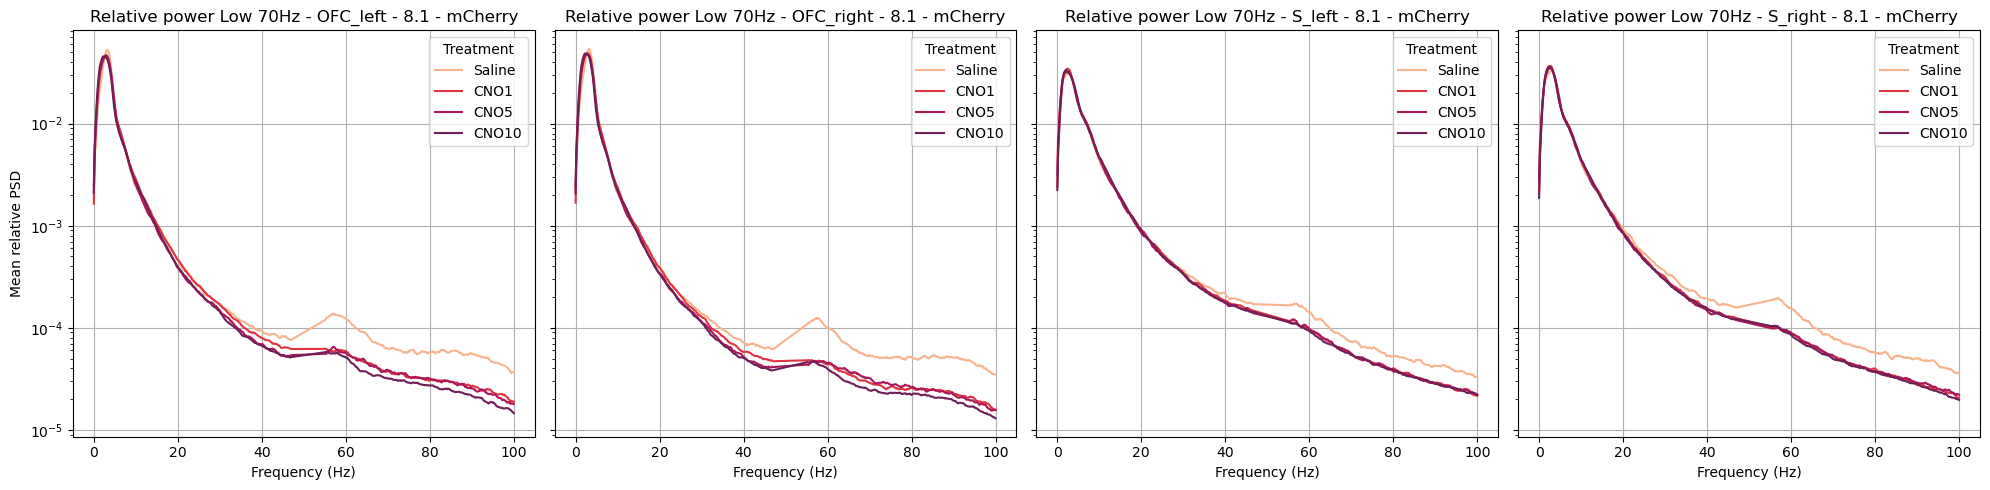

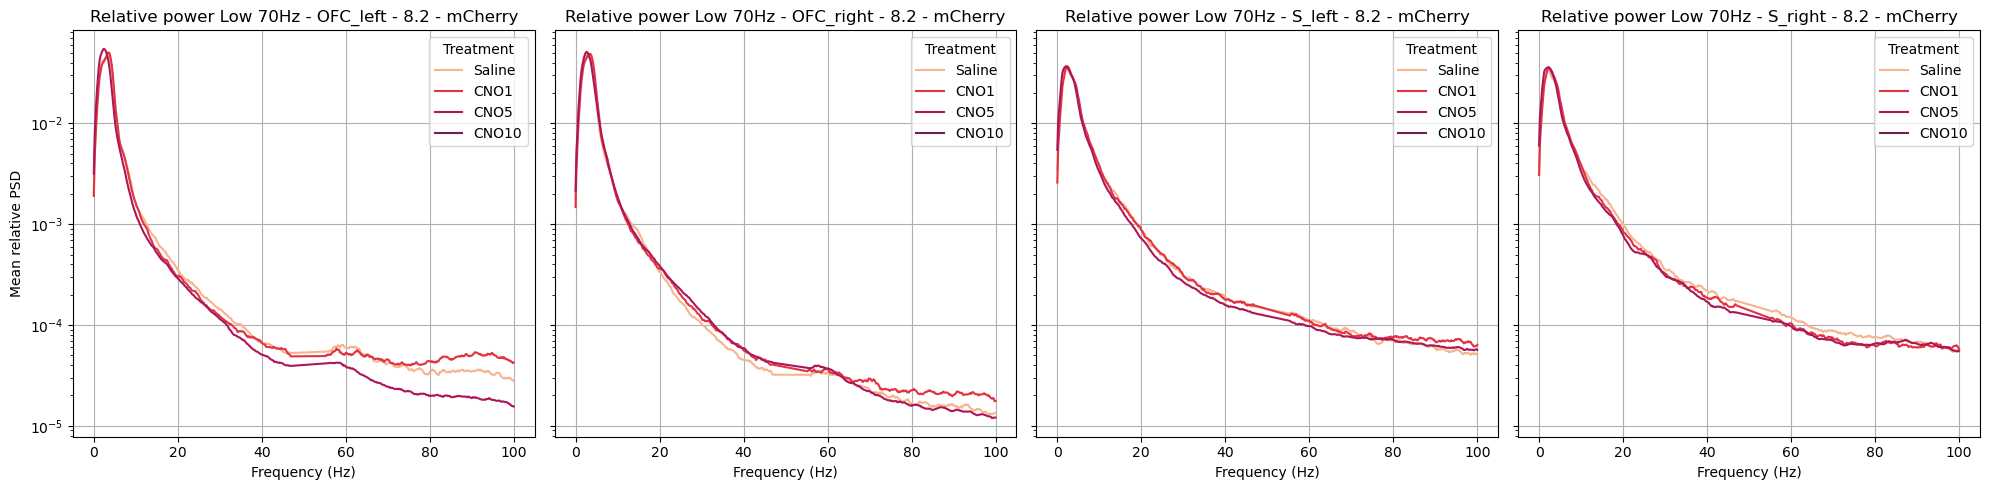

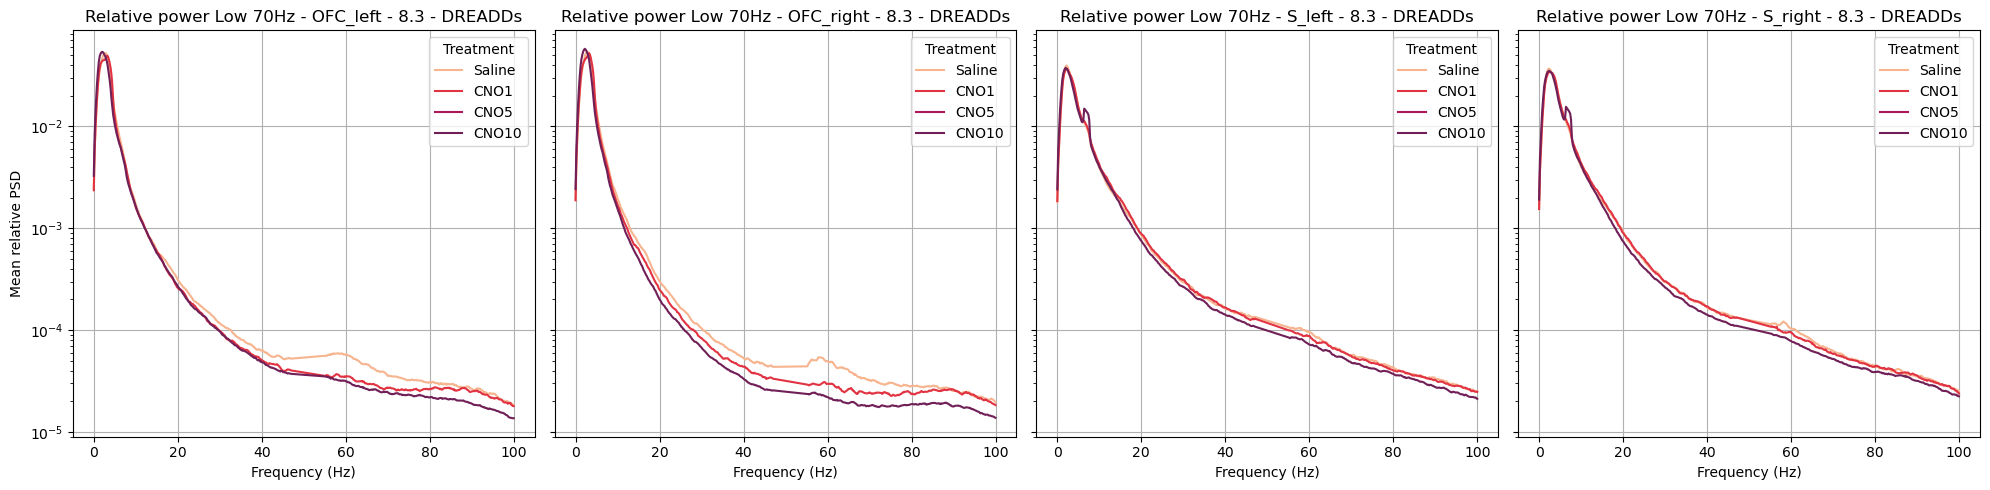

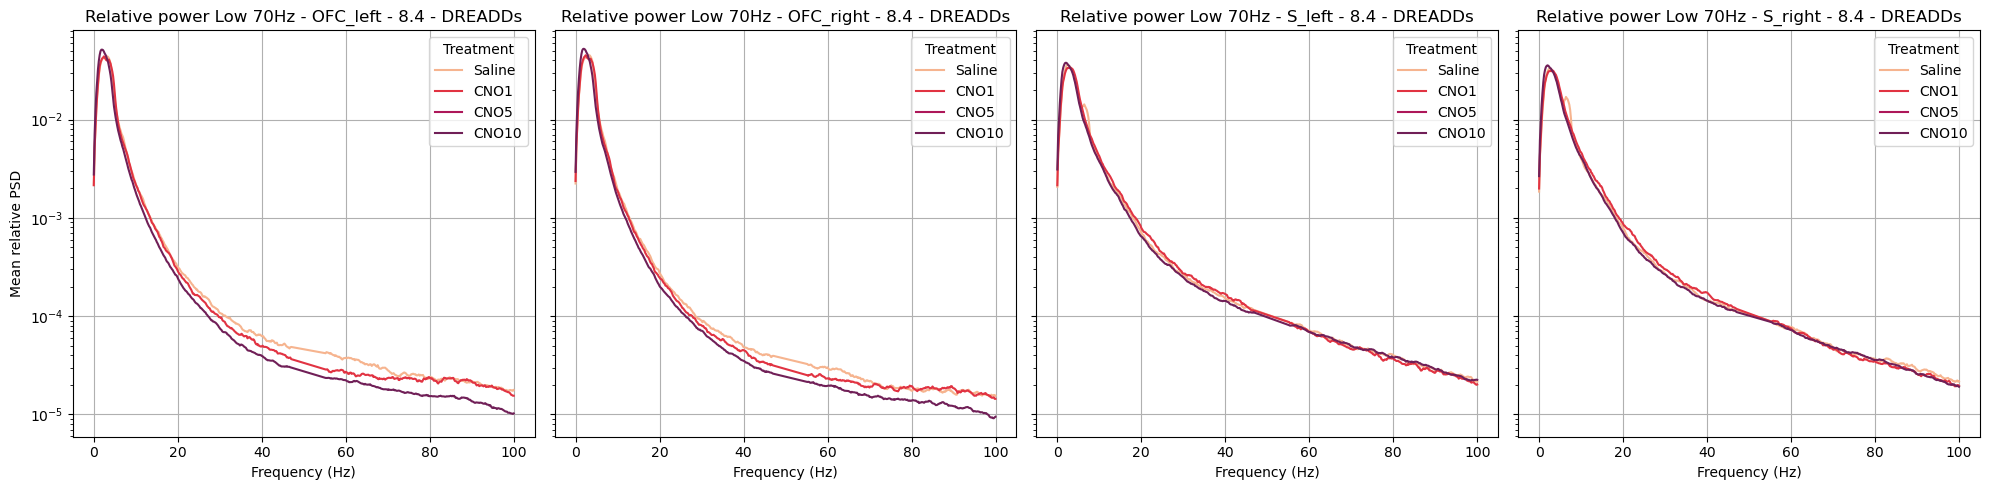

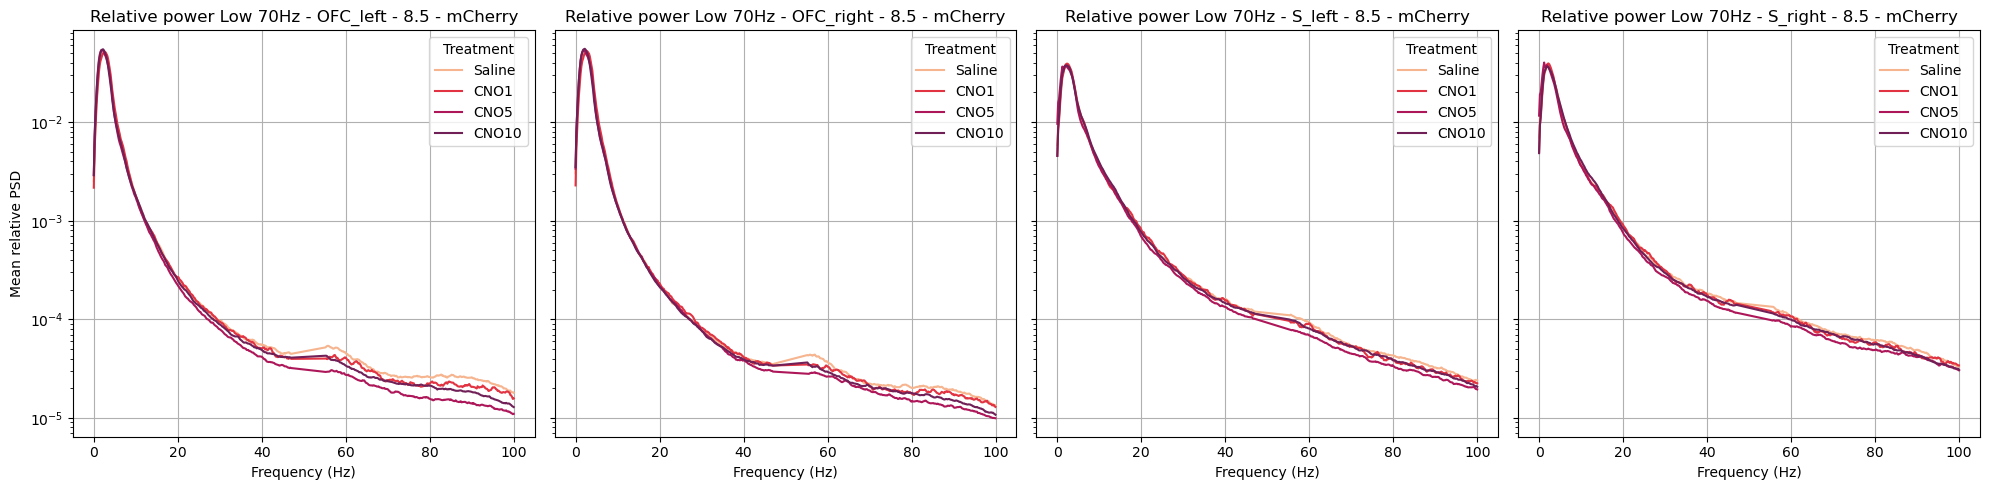

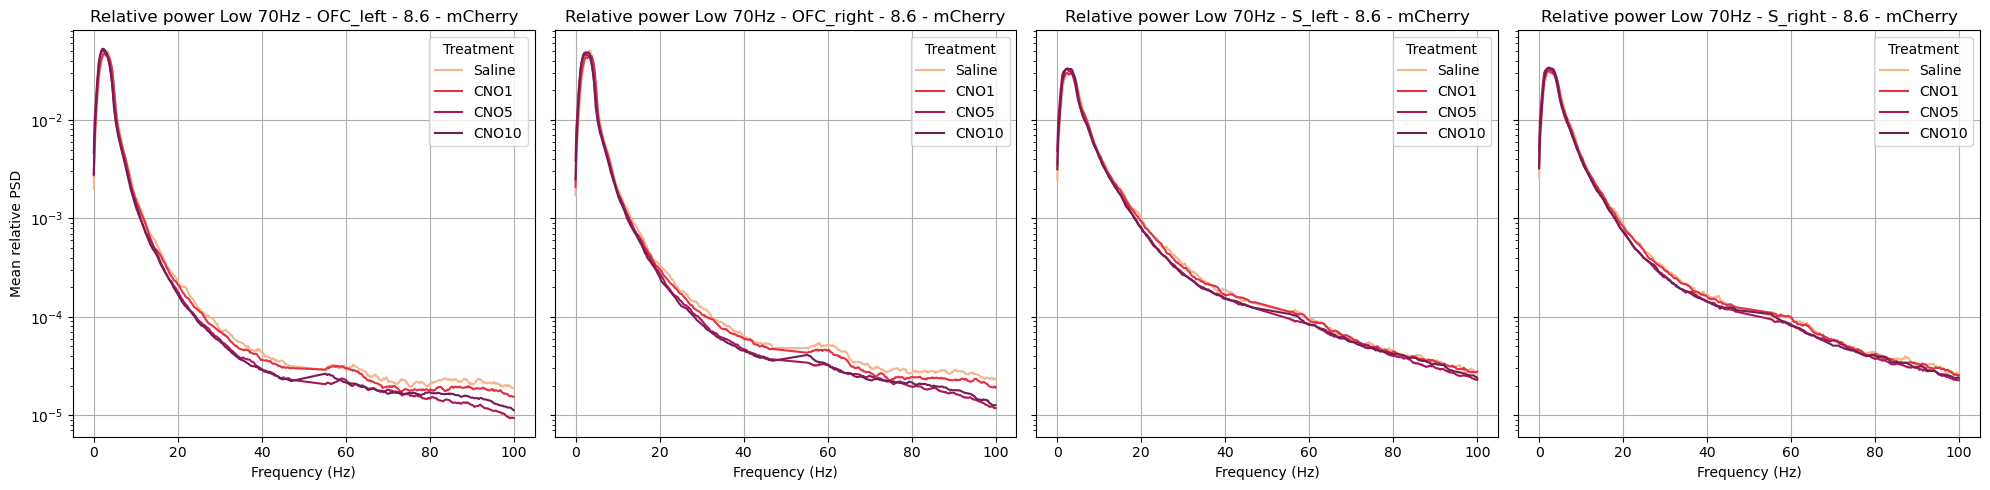

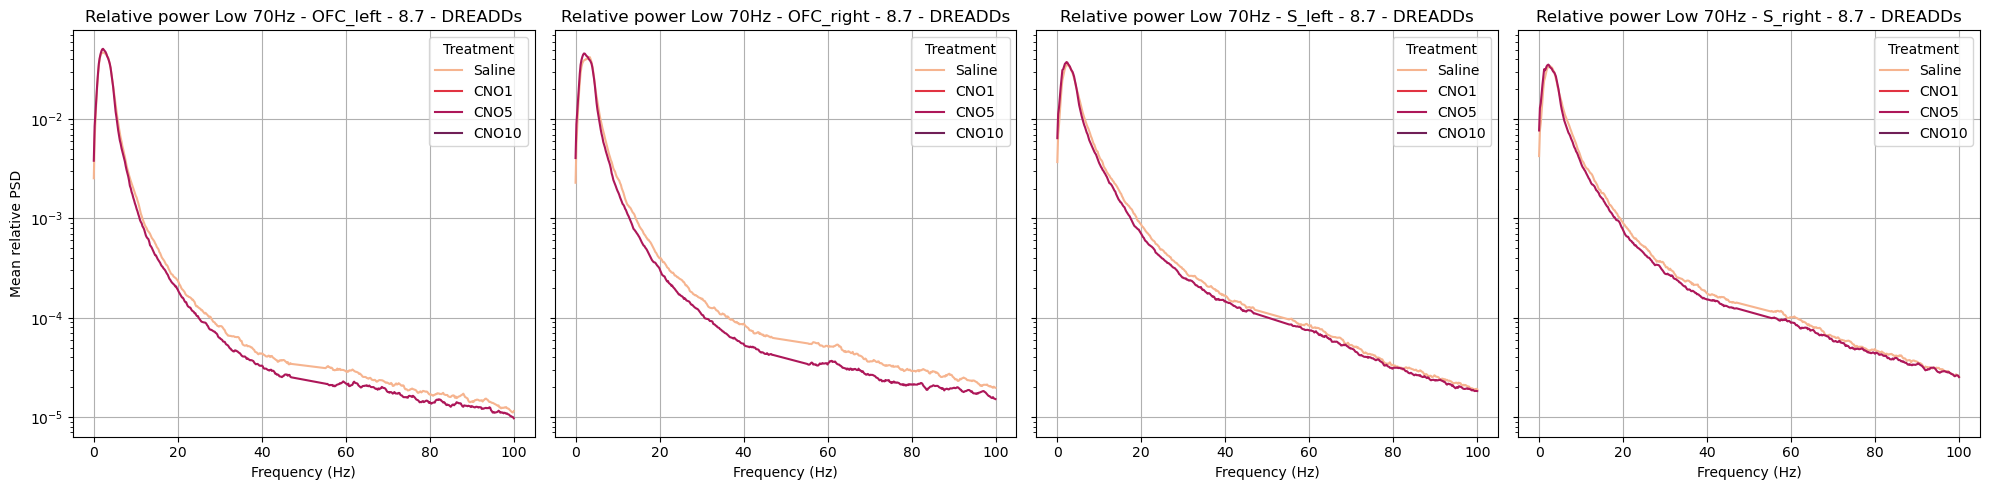

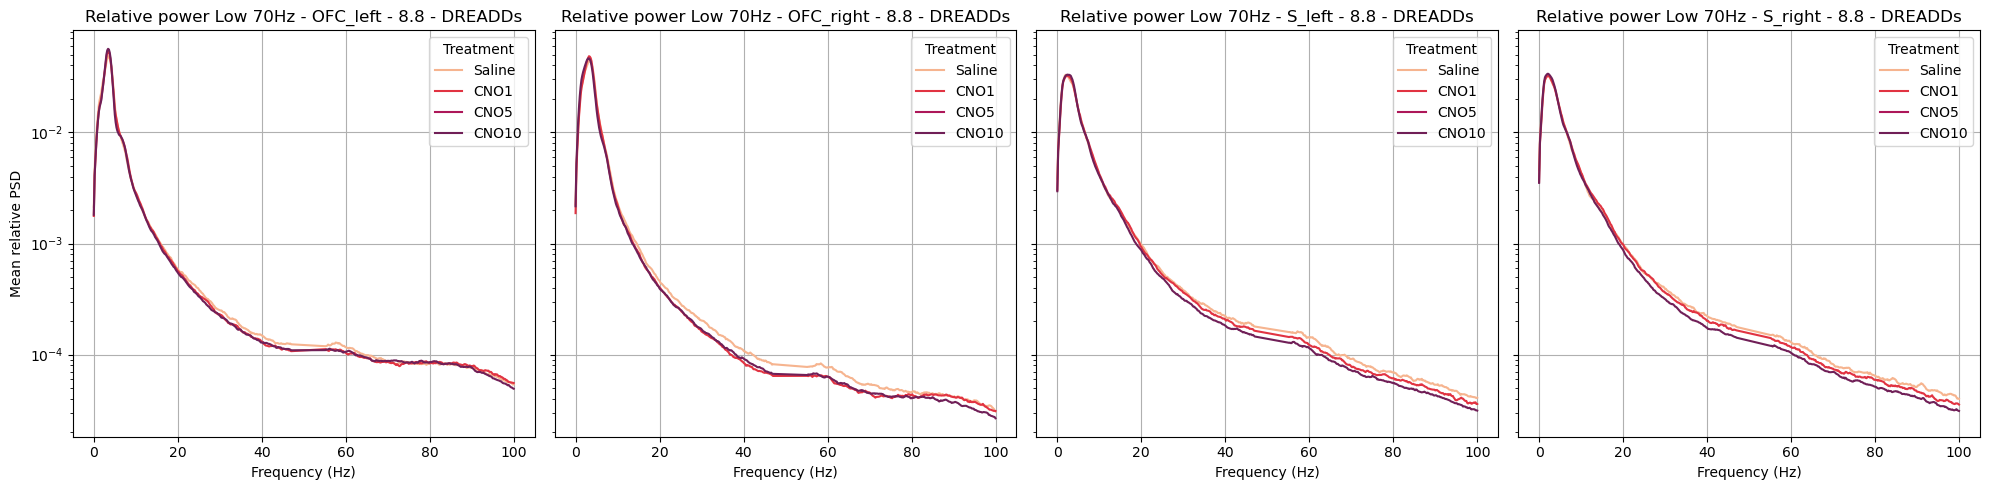

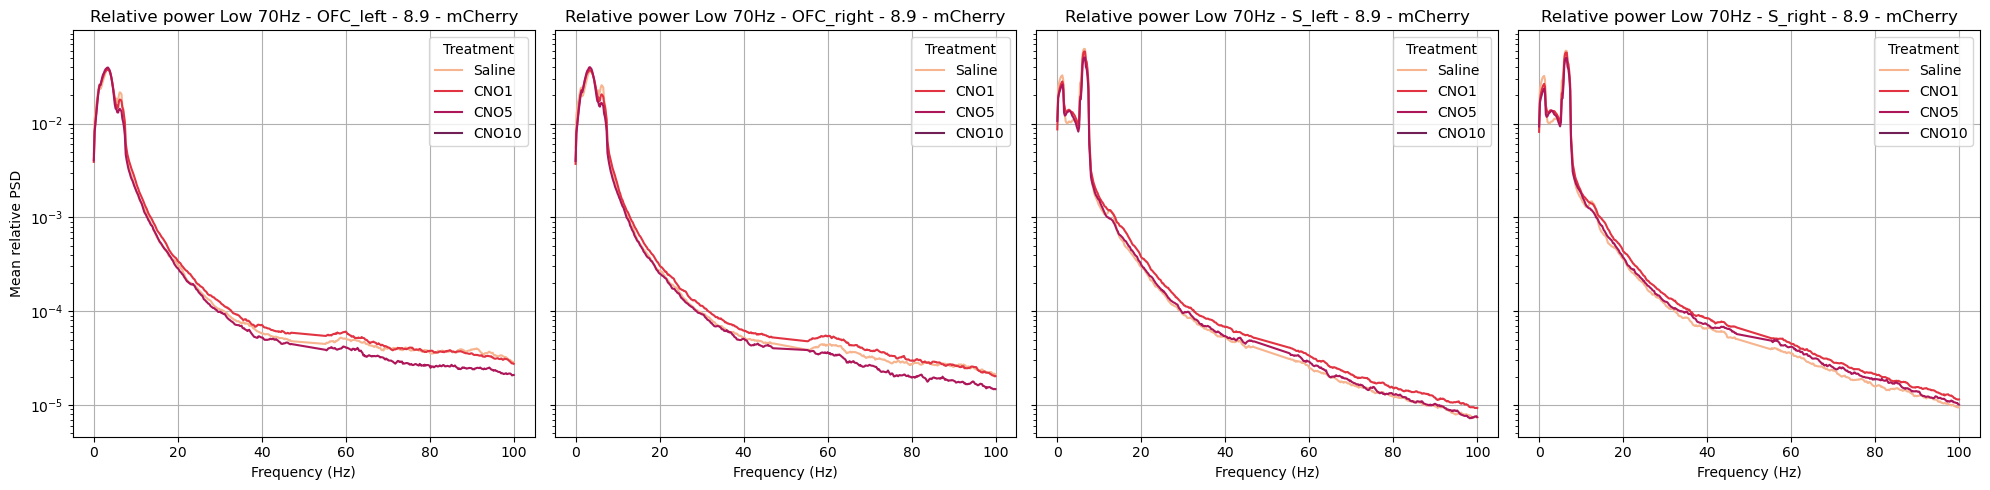

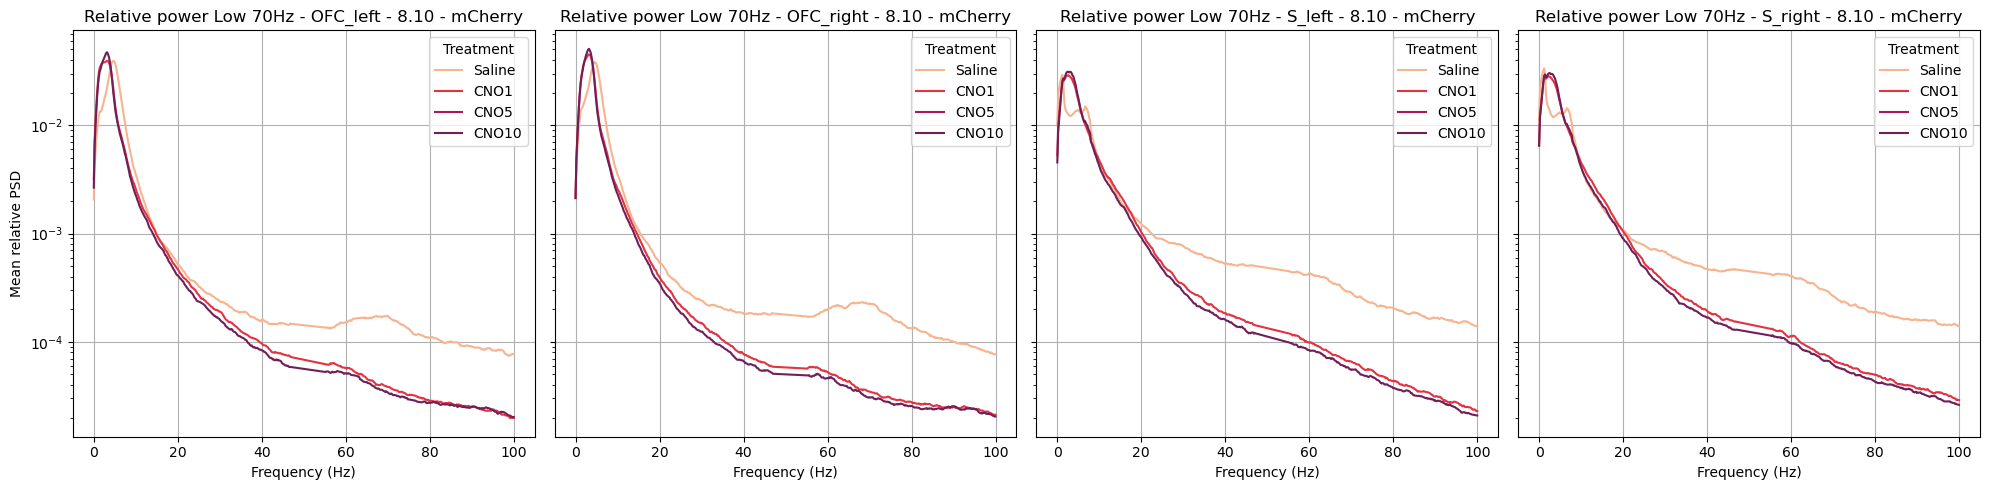

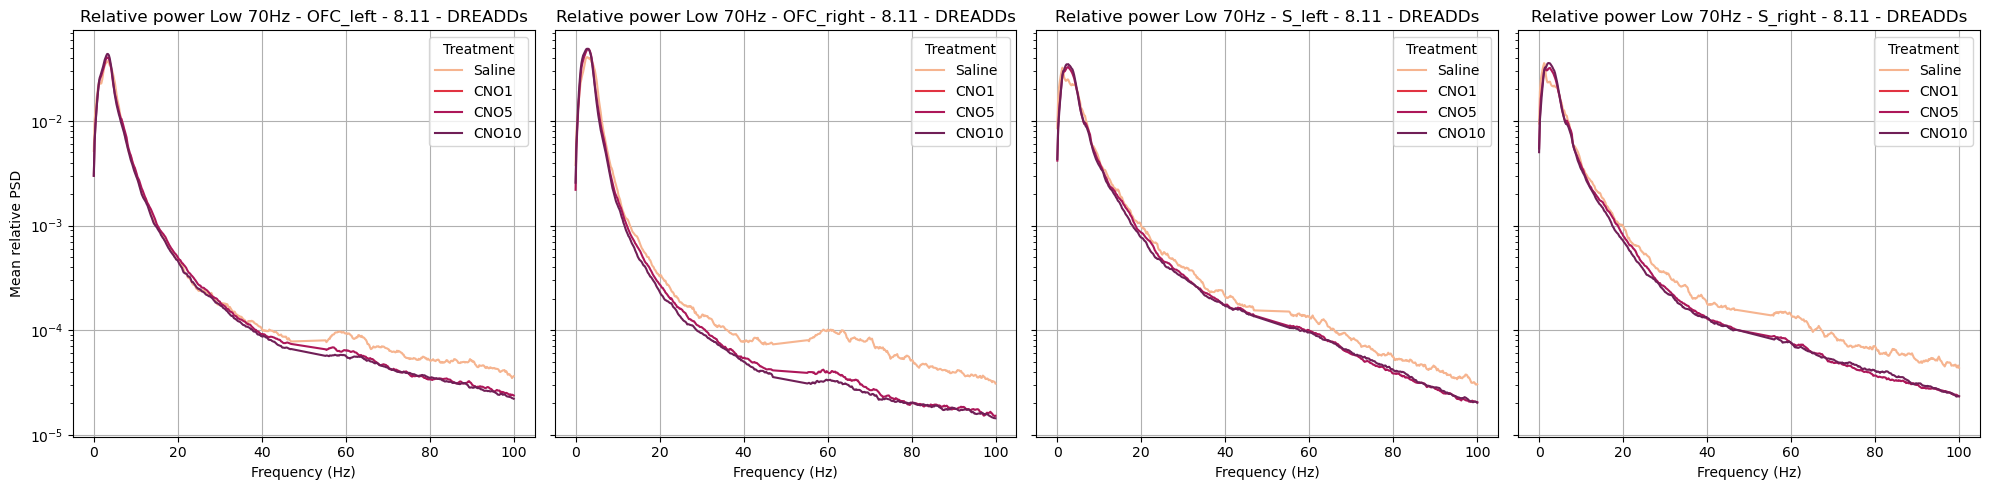

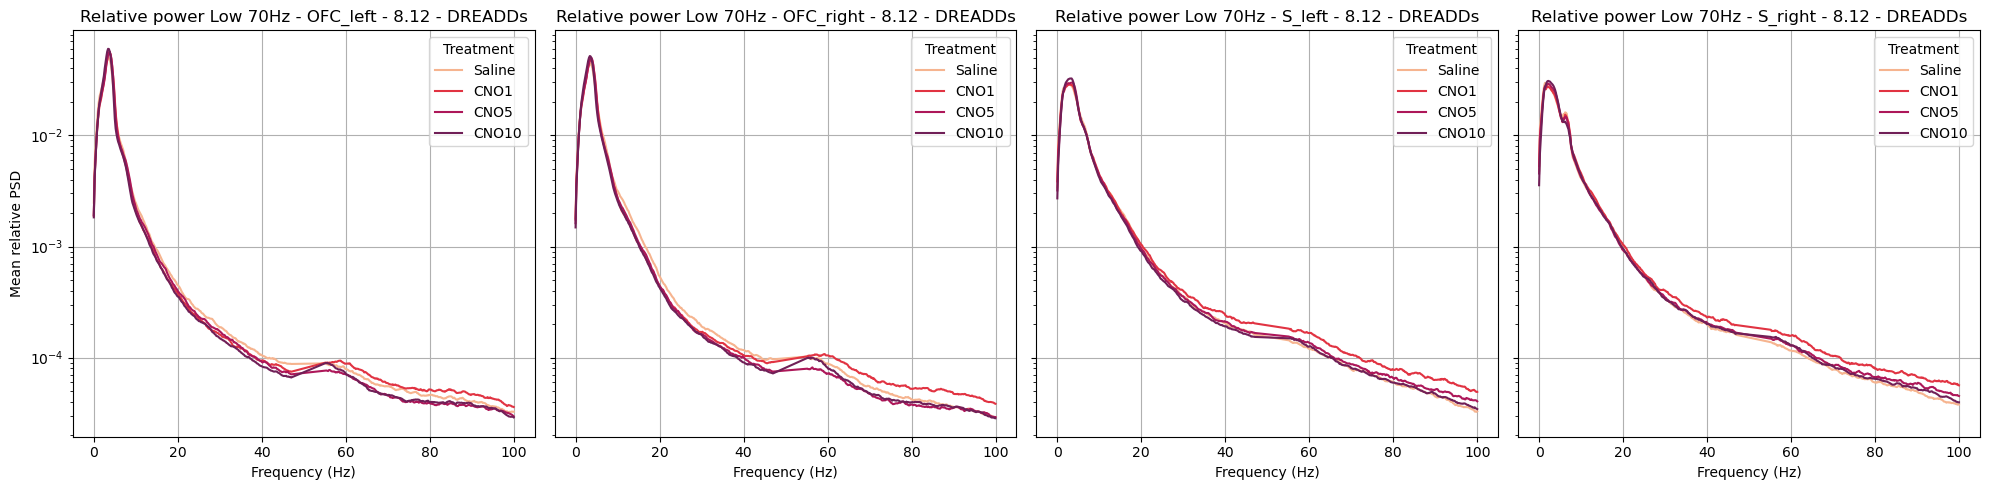

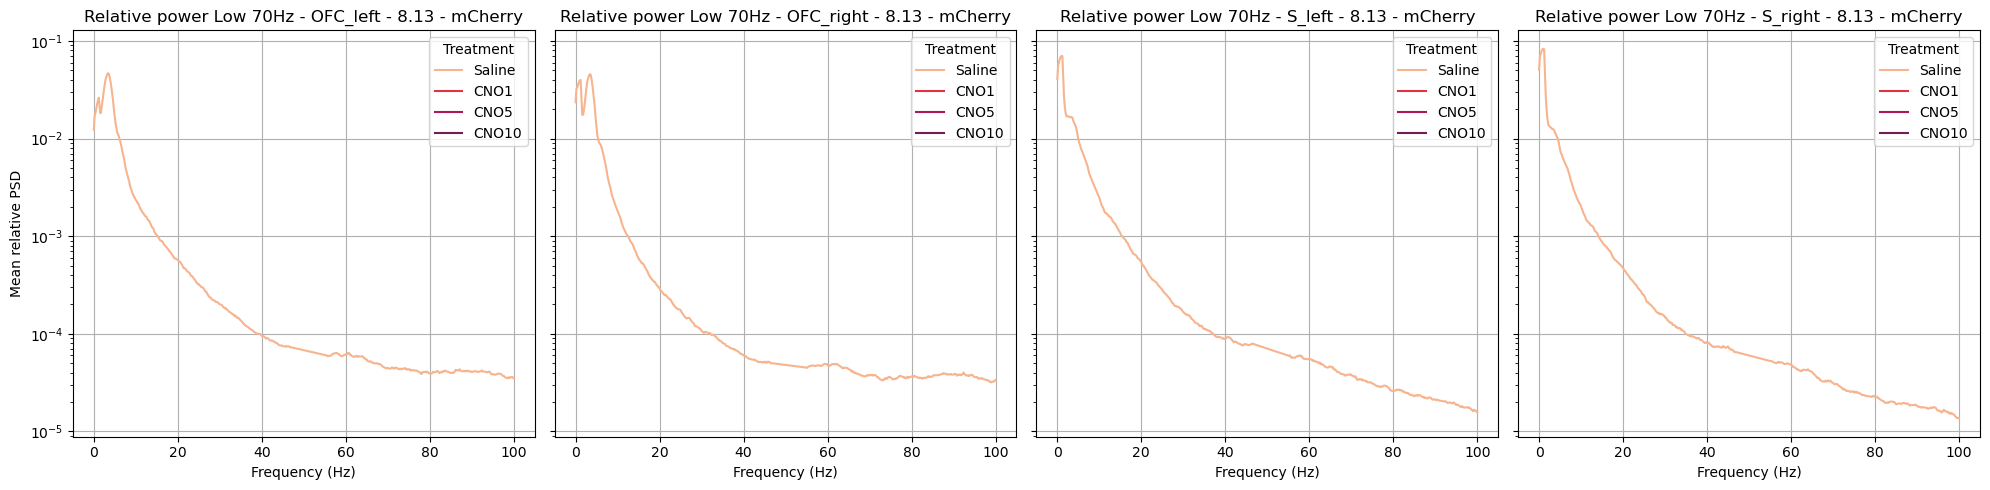

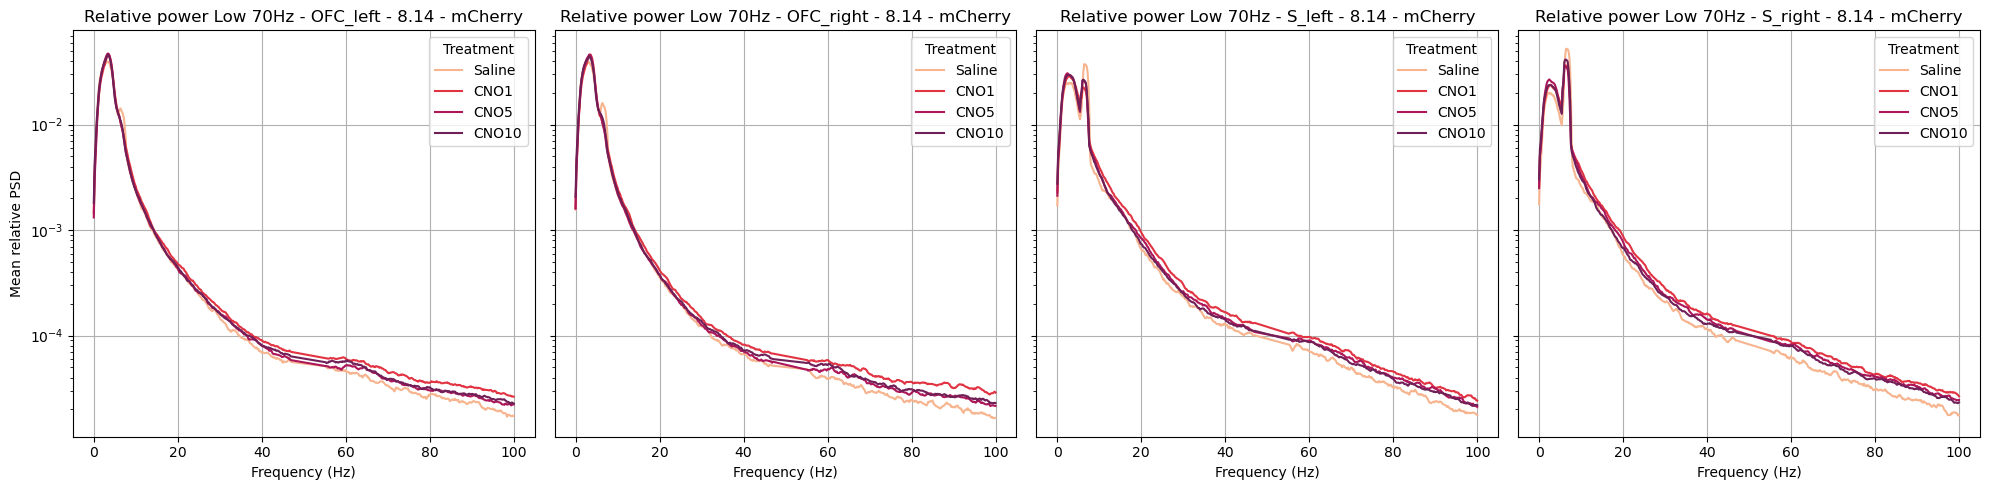

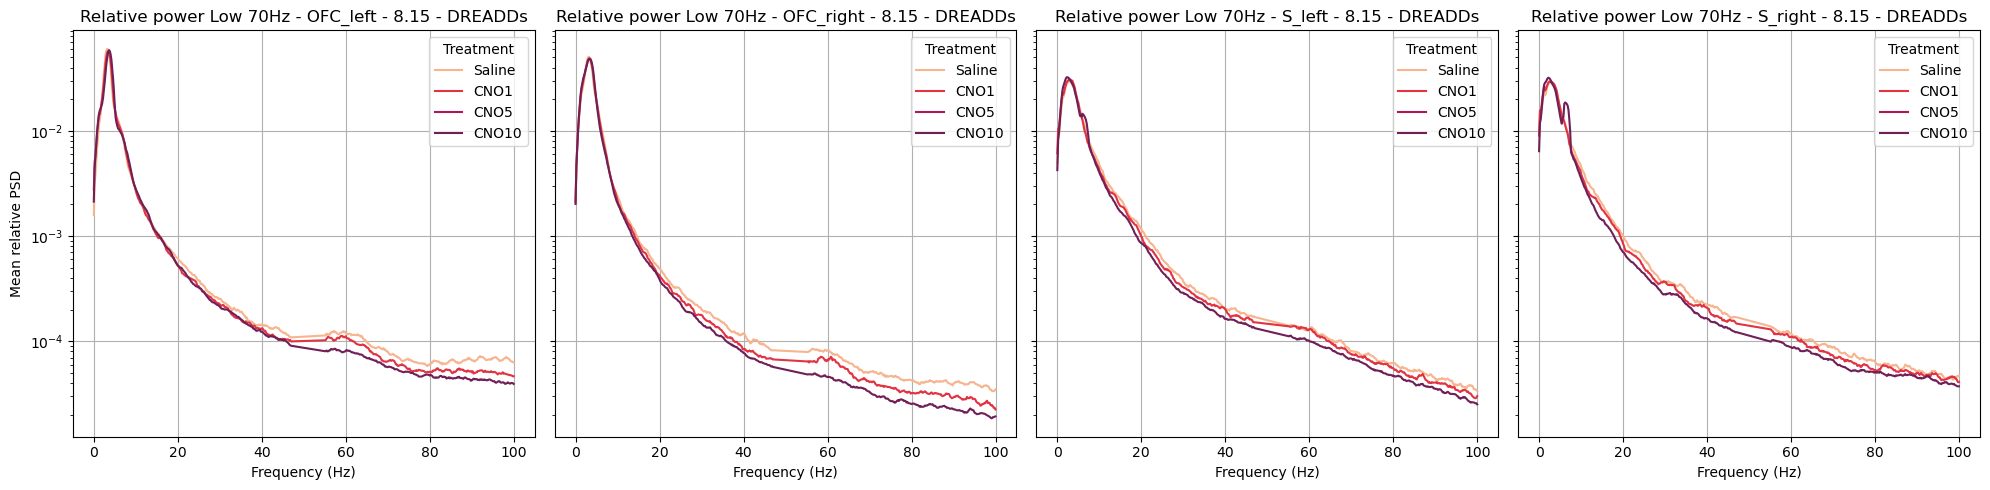

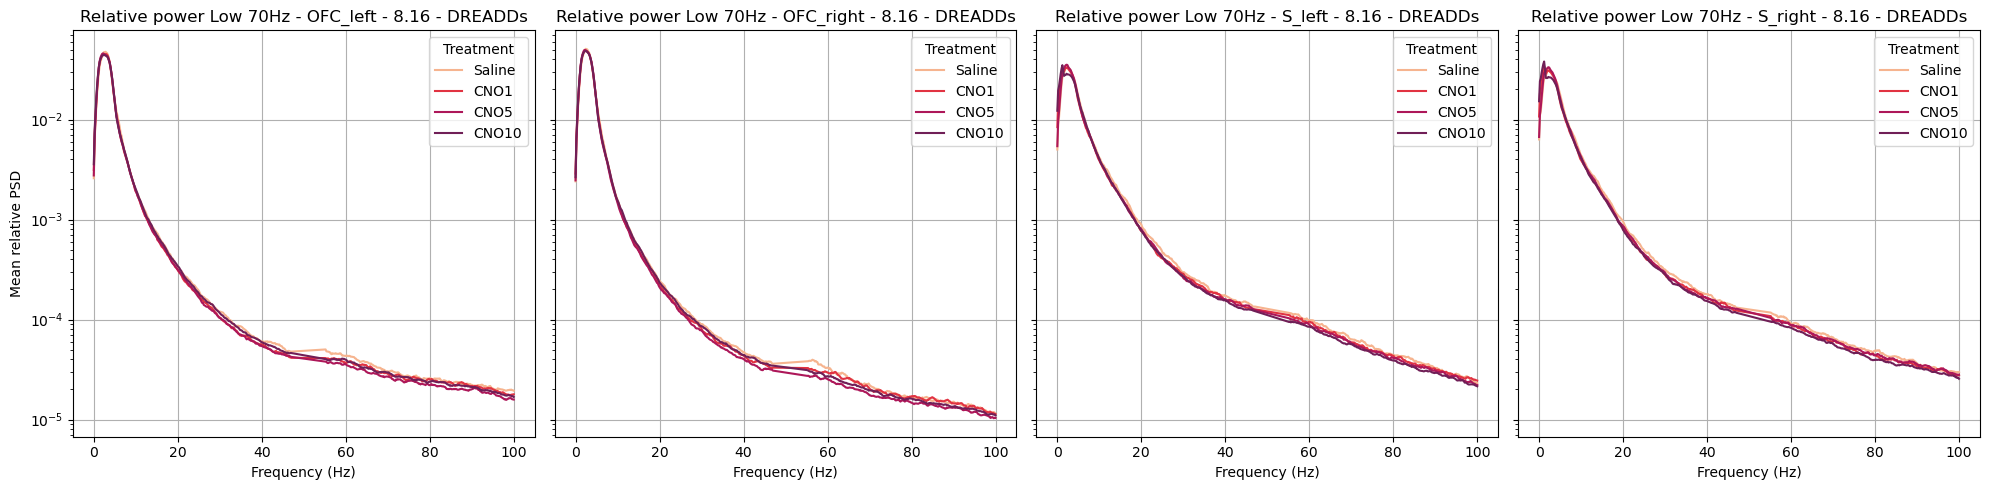

In [81]:
# Low 70 Hz
# Iterate over each animal
for animal_id in all_animals:
    # Create a figure and axes for each animal
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 5), sharey=True)
    
    # Filter dataframe for the current anima & exclude noise frequencies
    animal_df_clean = cluster_low70Hz[(cluster_low70Hz['Animal'] == animal_id) & ((cluster_low70Hz['Freqs'] > 55) | (cluster_low70Hz['Freqs'] < 47))]
    surgery = cluster_low70Hz[cluster_low70Hz['Animal'] == animal_id]['Surgery'].unique()[0]

    # Iterate over each channel
    for i, channel in enumerate(channel_order):
        # Filter dataframe and plot for the current channel
        channel_df = animal_df_clean[animal_df_clean['Channel'] == channel]
        sns.lineplot(data=channel_df, x='Freqs', y='Mean_rel_PSD', hue='Treatment',  
                     hue_order=legend_order, ax=axes[i], palette=custom_palette, errorbar=None)
        axes[i].set_yscale('log')
        axes[i].set_title(f'Relative power Low 70Hz - {channel} - {animal_id} - {surgery}')
        axes[i].set_xlabel('Frequency (Hz)')
        axes[i].set_ylabel('Mean relative PSD')
        axes[i].grid(True)
        axes[i].legend(title='Treatment')

    plt.tight_layout()
    plt.show()   
    

### Relative Power (individual)

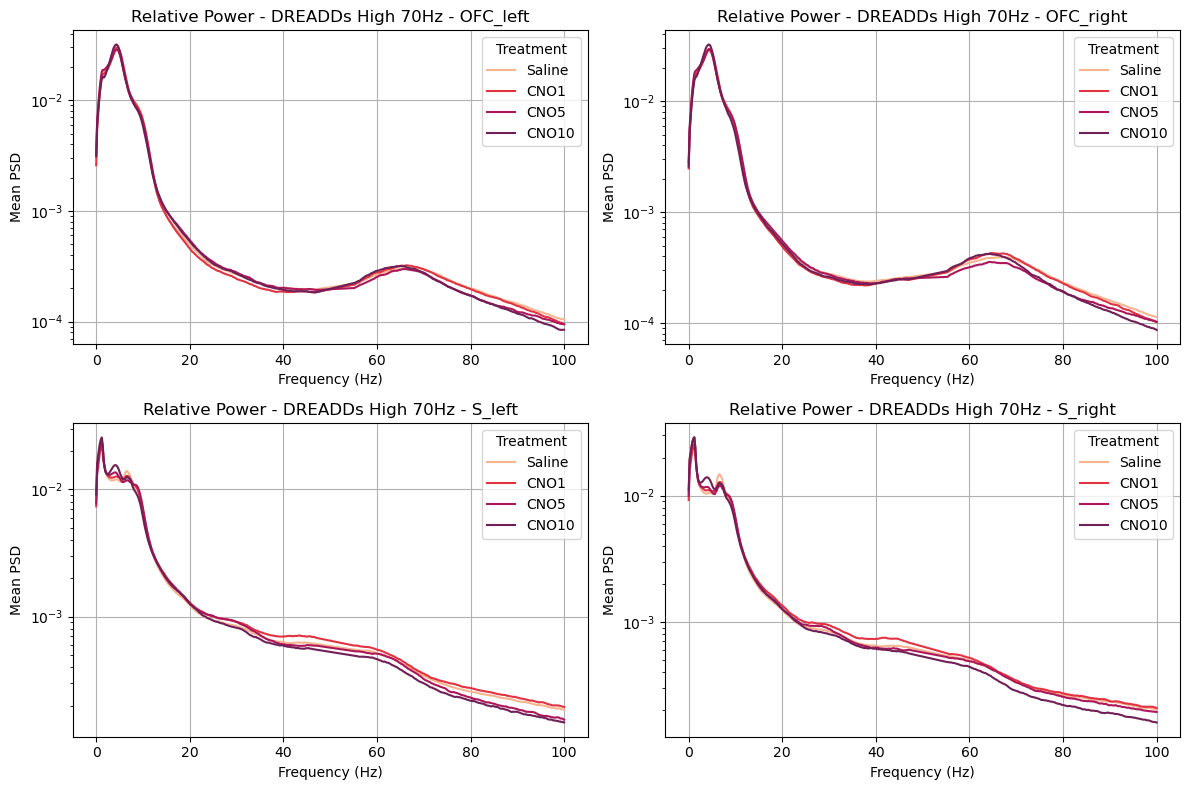

In [38]:
# dreadds high 70Hz
# plot individual RELATIVE power for mCherry subset, for each channel
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
axes = axes.ravel()

for i, channel in enumerate(channel_order):
    # Take out the frequencies between 47-55 Hz
    dreadd_high_clean = dreadd_high[(dreadd_high['Freqs']>55) | (dreadd_high['Freqs']<47)]
    sns.lineplot(data=dreadd_high_clean[dreadd_high_clean["Channel"]==channel], x='Freqs', y='Mean_rel_PSD', hue='Treatment',
                 hue_order=legend_order, ax=axes[i], palette=custom_palette, errorbar=None)
    axes[i].set_yscale('log')
    axes[i].set_title(f'Relative Power - DREADDs High 70Hz - {channel}')
    axes[i].set_xlabel('Frequency (Hz)')
    axes[i].set_ylabel('Mean PSD')
    axes[i].grid(True)
    axes[i].legend(title='Treatment')

plt.tight_layout()  
plt.show()

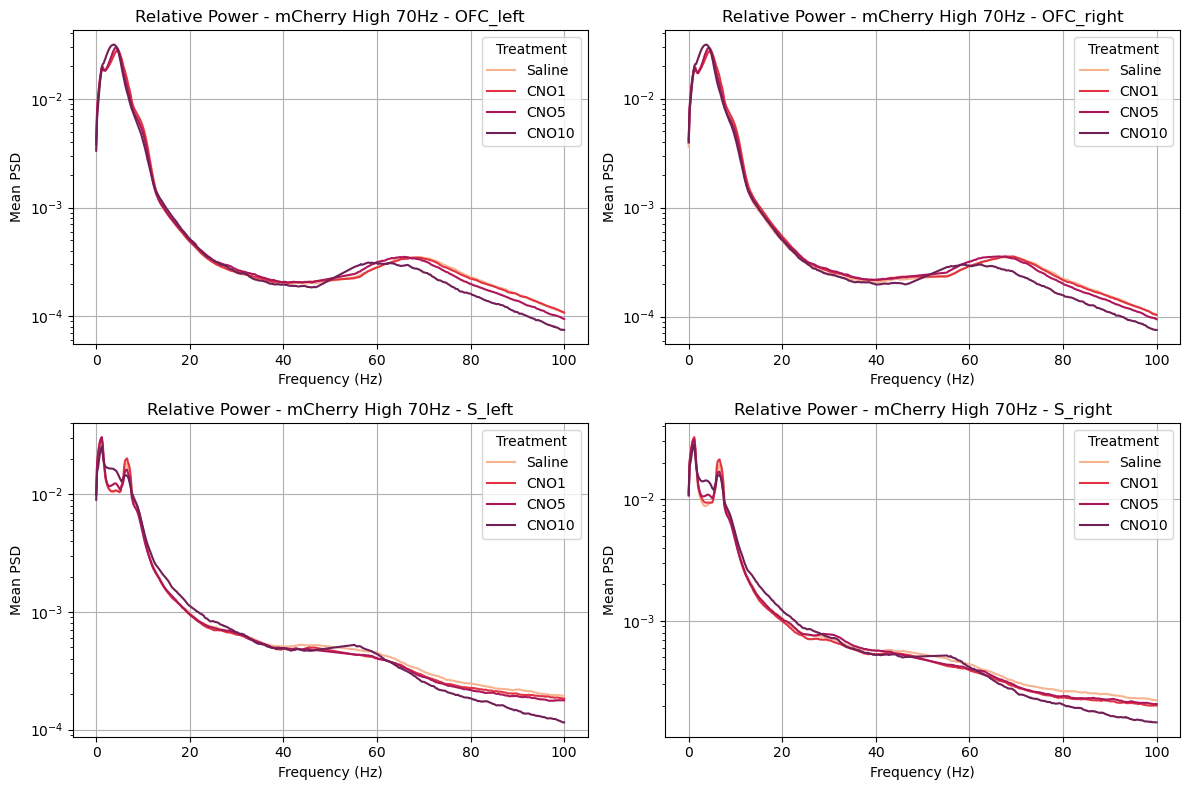

In [39]:
# mcherry high 70Hz
# plot individual RELATIVE power for mCherry subset, for each channel
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
axes = axes.ravel()

for i, channel in enumerate(channel_order):
    # Take out the frequencies between 47-55 Hz
    mcherry_high_clean = mcherry_high[(mcherry_high['Freqs']>55) | (mcherry_high['Freqs']<47)]
    sns.lineplot(data=mcherry_high_clean[mcherry_high_clean["Channel"]==channel], x='Freqs', y='Mean_rel_PSD', hue='Treatment',
                 hue_order=legend_order, ax=axes[i], palette=custom_palette, errorbar=None)
    axes[i].set_yscale('log')
    axes[i].set_title(f'Relative Power - mCherry High 70Hz - {channel}')
    axes[i].set_xlabel('Frequency (Hz)')
    axes[i].set_ylabel('Mean PSD')
    axes[i].grid(True)
    axes[i].legend(title='Treatment')

plt.tight_layout()  
plt.show()

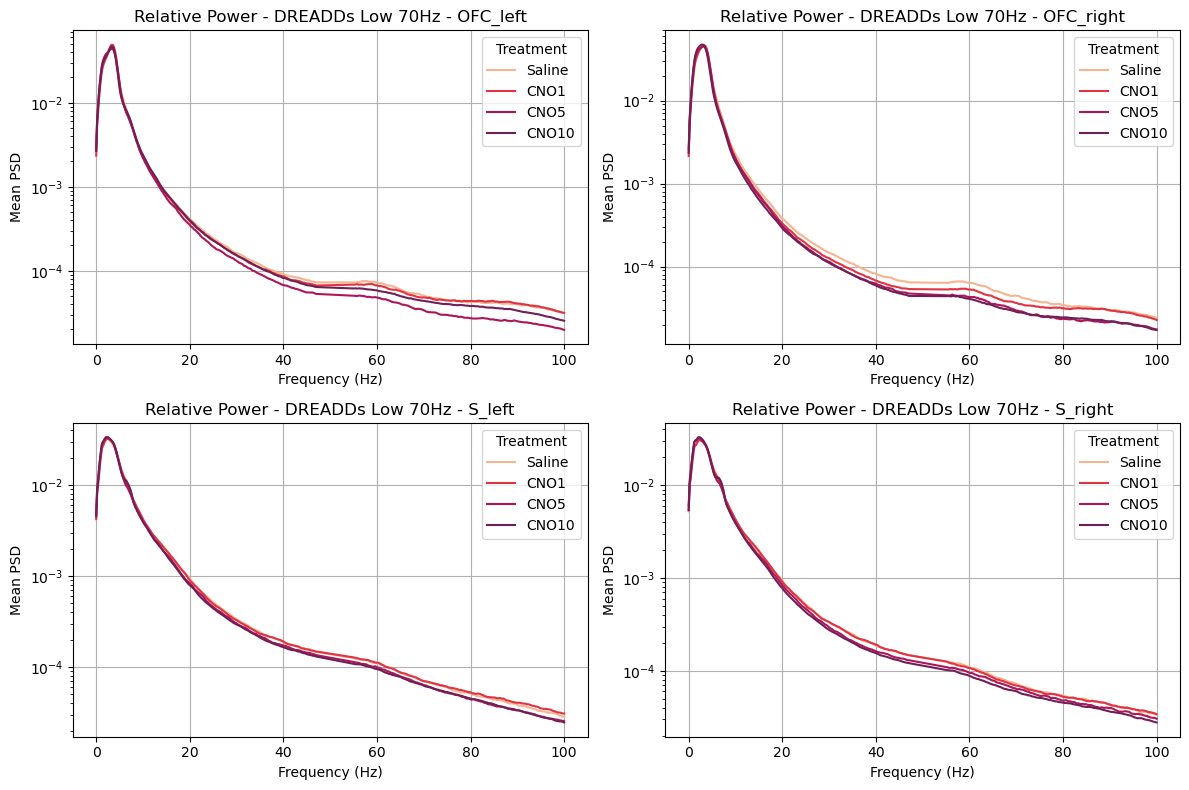

In [40]:
# dreadds low 70Hz
# plot individual RELATIVE power for mCherry subset, for each channel
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
axes = axes.ravel()

for i, channel in enumerate(channel_order):
    # Take out the frequencies between 47-55 Hz
    dreadd_low_clean = dreadd_low[(dreadd_low['Freqs']>55) | (dreadd_low['Freqs']<47)]
    sns.lineplot(data=dreadd_low_clean[dreadd_low_clean["Channel"]==channel], x='Freqs', y='Mean_rel_PSD', hue='Treatment',
                 hue_order=legend_order, ax=axes[i], palette=custom_palette, errorbar=None)
    axes[i].set_yscale('log')
    axes[i].set_title(f'Relative Power - DREADDs Low 70Hz - {channel}')
    axes[i].set_xlabel('Frequency (Hz)')
    axes[i].set_ylabel('Mean PSD')
    axes[i].grid(True)
    axes[i].legend(title='Treatment')

plt.tight_layout()  
plt.show()

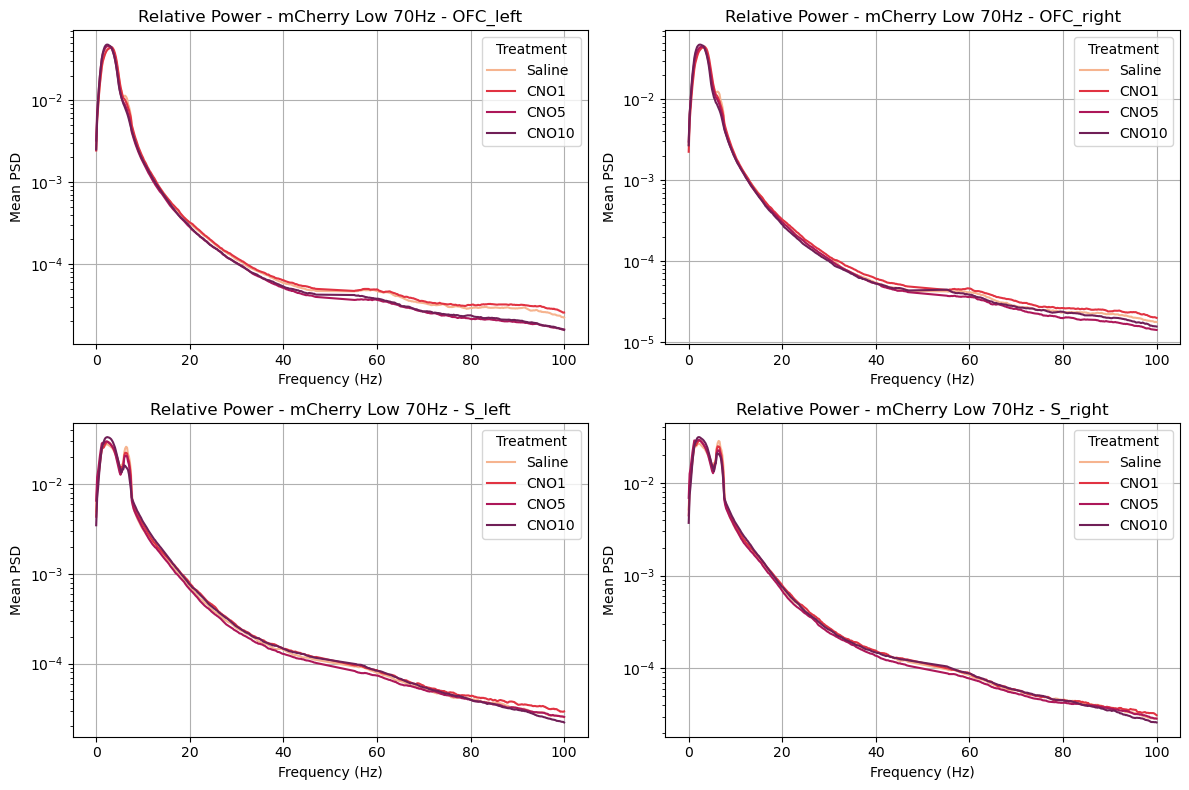

In [41]:
# mcherry low 70Hz
# plot individual RELATIVE power for mCherry subset, for each channel
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
axes = axes.ravel()

for i, channel in enumerate(channel_order):
    # Take out the frequencies between 47-55 Hz
    mcherry_low_clean = mcherry_low[(mcherry_low['Freqs']>55) | (mcherry_low['Freqs']<47)]
    sns.lineplot(data=mcherry_low_clean[mcherry_low_clean["Channel"]==channel], x='Freqs', y='Mean_rel_PSD', hue='Treatment',
                 hue_order=legend_order, ax=axes[i], palette=custom_palette, errorbar=None)
    axes[i].set_yscale('log')
    axes[i].set_title(f'Relative Power - mCherry Low 70Hz - {channel}')
    axes[i].set_xlabel('Frequency (Hz)')
    axes[i].set_ylabel('Mean PSD')
    axes[i].grid(True)
    axes[i].legend(title='Treatment')

plt.tight_layout()  
plt.show()

### Saline

ValueError: cannot reindex on an axis with duplicate labels

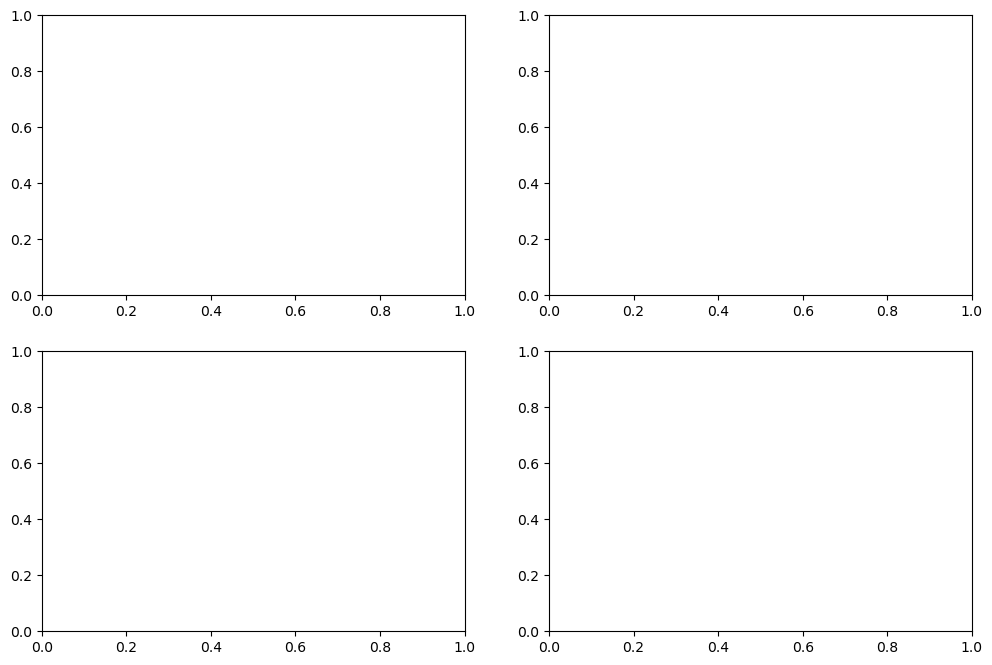

In [26]:
# Low 70Hz
# Plot RELATIVE power for all animals for saline condition
# Subset df for Saline treatment
saline_rel_data = cluster_low70Hz[cluster_low70Hz['Treatment'] == 'Saline']

# Create subplots for each channel
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
axes = axes.ravel()

# Plot aggregated data for Saline treatment, with different animals as hue
for i, (channel, ax) in enumerate(zip(channel_order, axes)):
    cleaned = saline_rel_data[saline_rel_data['Channel'] == channel]

    # Take out the frequencies between 47-55 Hz
    cleaned = cleaned[(cleaned['Freqs']>55) | (cleaned['Freqs']<47)]
    sns.lineplot(data=cleaned[cleaned["Channel"]==channel], x='Freqs', y='Mean_rel_PSD',
                  hue='Animal', ax=ax, errorbar='se')
    ax.set_yscale('log')
    ax.set_title(f'Relative Power - Saline - Low 70Hz {channel}, {duration_hours}hr')
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Mean PSD')
    ax.grid(True)
    ax.legend(title='Animal', bbox_to_anchor=(1.25, 1.2), loc='upper right')

plt.tight_layout()  
plt.show()

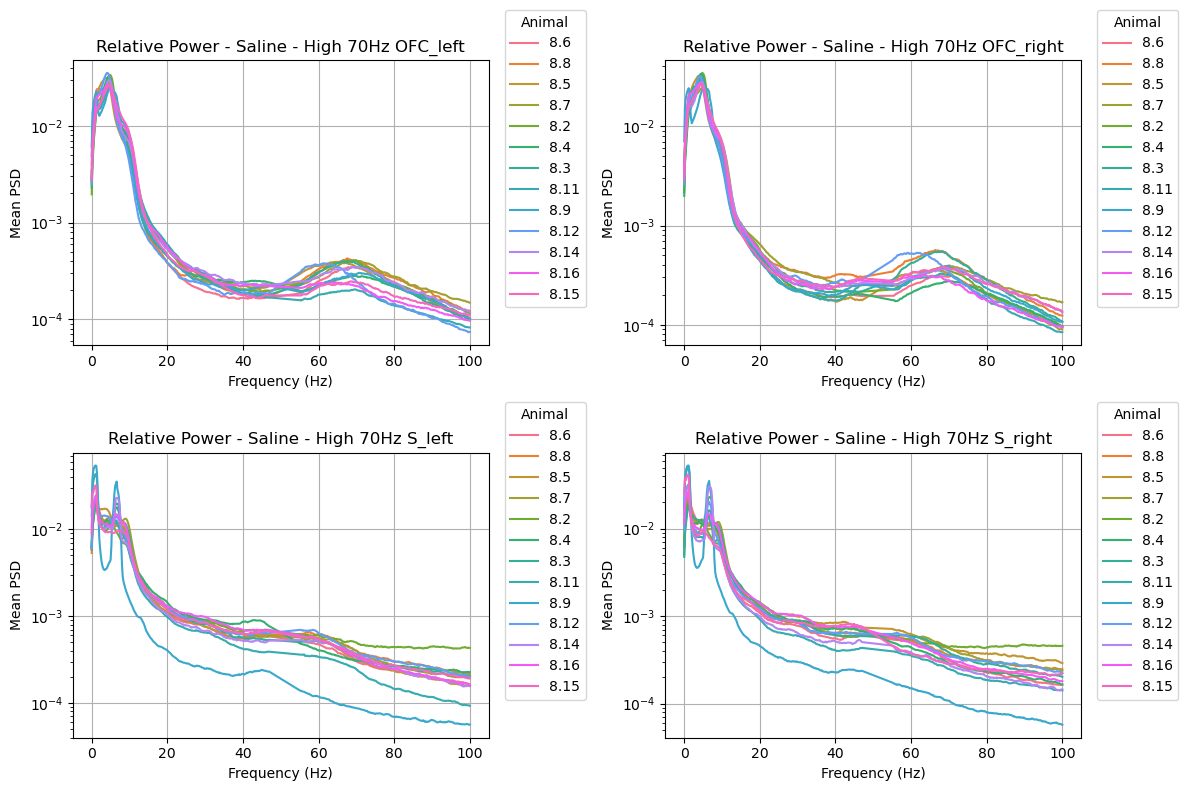

In [ ]:
# High 70Hz
# Plot RELATIVE power for all animals for saline condition
# Subset df for Saline treatment
saline_rel_data = cluster_high70Hz[cluster_high70Hz['Treatment'] == 'Saline']

# Create subplots for each channel
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
axes = axes.ravel()

# Plot aggregated data for Saline treatment, with different animals as hue
for i, (channel, ax) in enumerate(zip(channel_order, axes)):
    cleaned = saline_rel_data[saline_rel_data['Channel'] == channel]

    # Take out the frequencies between 47-55 Hz
    cleaned = cleaned[(cleaned['Freqs']>55) | (cleaned['Freqs']<47)]
    sns.lineplot(data=cleaned[cleaned["Channel"]==channel], x='Freqs', y='Mean_rel_PSD',
                  hue='Animal', ax=ax, errorbar='se')
    ax.set_yscale('log')
    ax.set_title(f'Relative Power - Saline - High 70Hz {channel}, {duration_hours}hr')
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Mean PSD')
    ax.grid(True)
    ax.legend(title='Animal', bbox_to_anchor=(1.25, 1.2), loc='upper right')

plt.tight_layout()  
plt.show()

### Power relative to saline condition

In [81]:
# Define function to plot PSD relative to saline
def plot_rel_psd(data, errorbar='ci', min_noise_freq=47, max_noise_freq=55):
    """ 
    Takes:
    The dataset 
    The type of errorbar (standard: confidence interval), 
    The frequencies between minimum and maximum noise frequencies (standard 47 and 55) are taken out
    """
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
    axes = axes.ravel()

    # Extract unique values for dynamic plot titles
    surgery = data['Surgery'].unique()[0]
    cluster_label = data['Cluster_Label'].unique()[0]

    for i, channel in enumerate(channel_order):
        cleaned = data[data['Channel'] == channel]
        # Remove frequencies between min_noise_freq and max_noise_freq
        cleaned = cleaned[(cleaned['Freqs'] > max_noise_freq) | (cleaned['Freqs'] < min_noise_freq)]
        sns.lineplot(data=cleaned, x='Freqs', y='normalized_power', hue='Treatment',  ax=axes[i],  
                     errorbar=errorbar, hue_order=legend_order, palette=custom_palette)

        axes[i].set_ylim(0, 200)
        axes[i].set_title(f'Relative Power - {surgery} - {cluster_label} - {channel}, {duration_hours}hr')
        axes[i].set_xlabel('Frequency (Hz)')
        axes[i].set_ylabel('Relative Mean PSD (%)')
        axes[i].grid(True)
        axes[i].legend(title='Treatment')

    plt.tight_layout()
    plt.show()

Plots

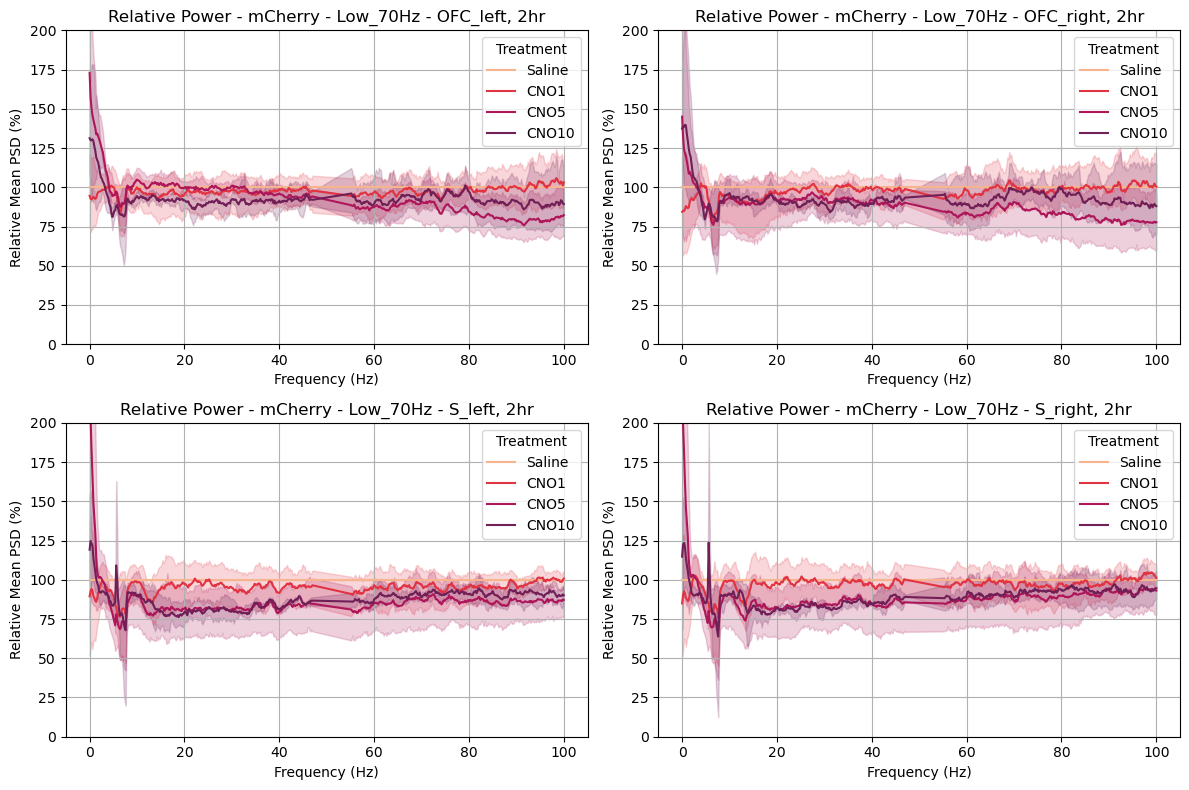

In [97]:
plot_rel_psd(mcherry_norm_low, 'ci', 47, 55)


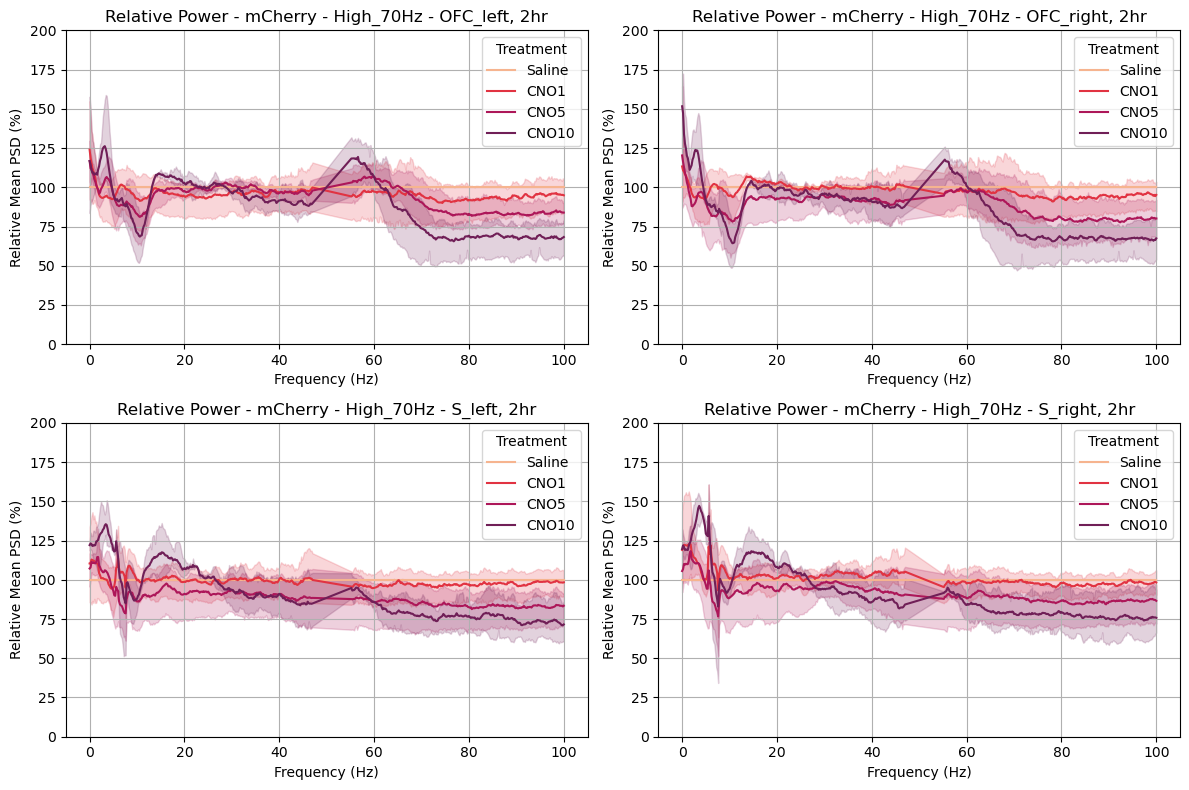

In [98]:
plot_rel_psd(mcherry_norm_high, 'ci', 47, 55)


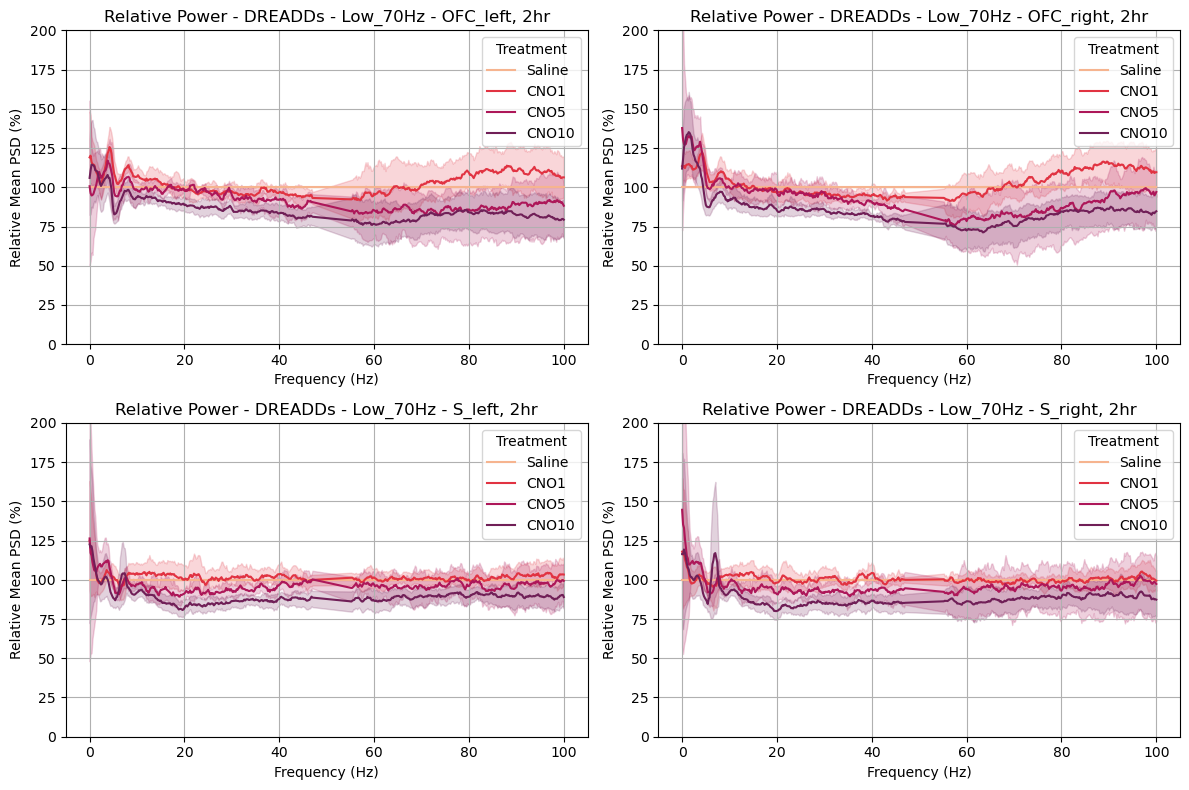

In [99]:
plot_rel_psd(dreadd_norm_low, 'ci', 47, 55)


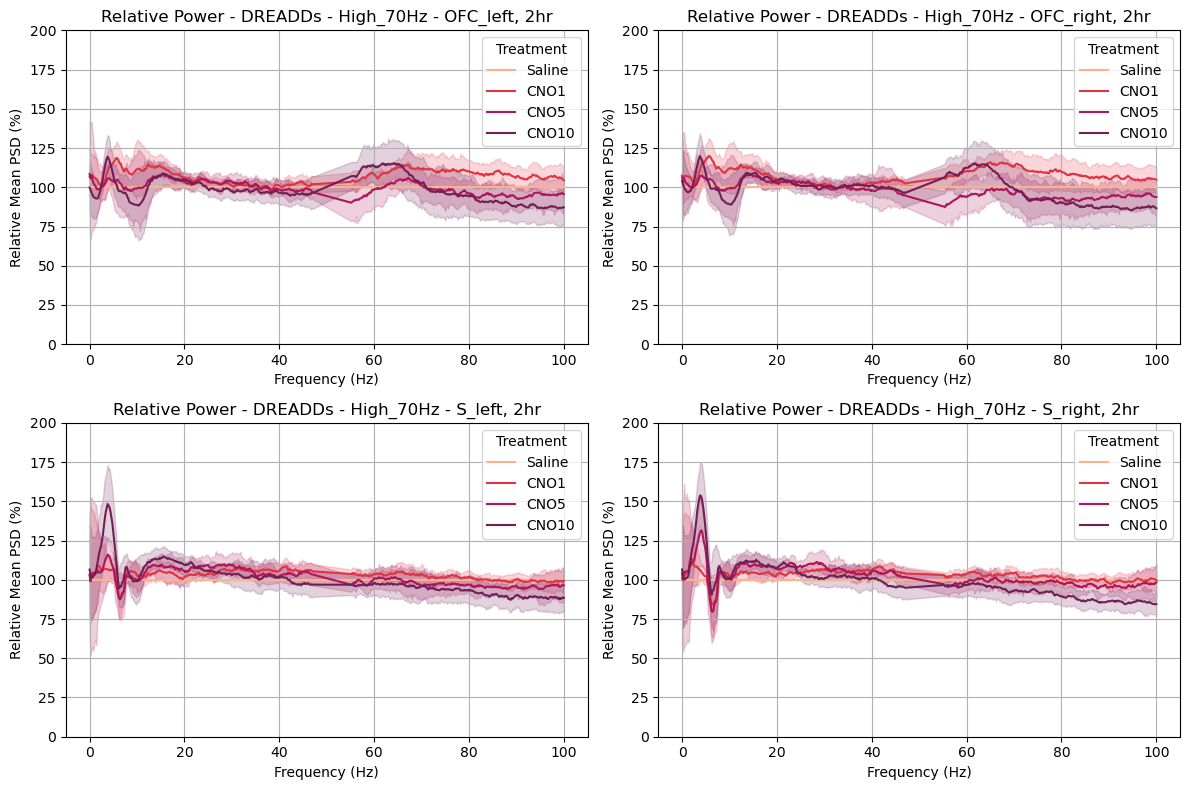

In [100]:
plot_rel_psd(dreadd_norm_high, 'ci', 47, 55)
